Felix Waldschock | 2024
AML TIF360
Assigment D -- Reservoir Computing


Subtask 1.)
Generate a training set of time series x2(t) by by numerical solution of Equation (4), for σ = 10, r = 28, and b = 8/3. See Exercise 3.2 in Nonlinear time series analysis by Kantz and Schreiber [10] (2pt).


In [78]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scienceplots
from tqdm import trange
plt.style.use('science')


In [79]:
def lorenzSystem(x0,y0,z0,s, r, b, numIter, dt):
    xTracker = []
    yTracker = []
    zTracker = []
    timeTracker = []
    x = x0
    y = y0
    z = z0
    for i in range(numIter):
        dx = -s*x + s * y 
        dy = -x * z + r * x - y
        dz = x * y - b * z
        x += dx * dt
        y += dy * dt
        z += dz * dt
        xTracker.append(x)
        yTracker.append(y)
        zTracker.append(z)
        timeTracker.append(i*dt)

    return np.array(xTracker), np.array(yTracker), np.array(zTracker), np.array(timeTracker)

In [80]:
x, y, z, t = lorenzSystem(1,0,0,10,28,8/3, numIter=10_000, dt=0.01)

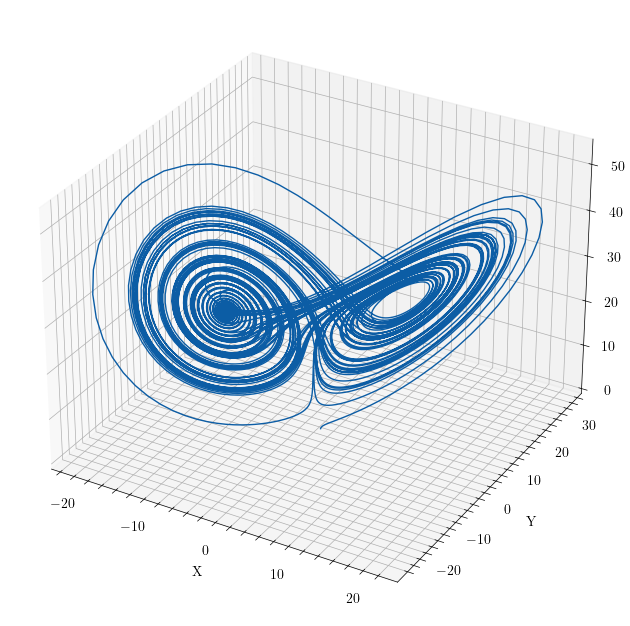

In [81]:
# visualize in 3d
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x,y,z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


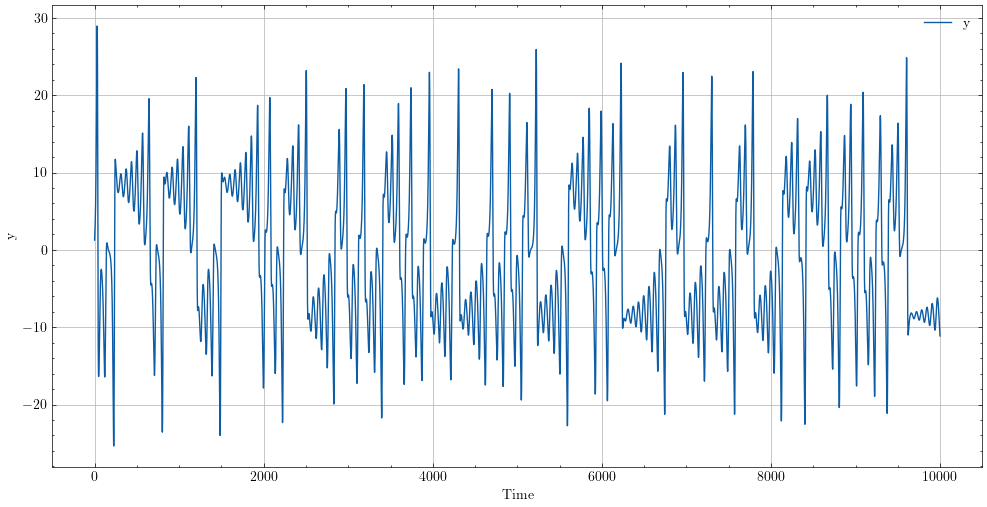

In [116]:
# visualize the y (x2) component over time
plt.figure(figsize=(12,6))
plt.plot(y, label='y')
plt.grid()
plt.xlabel('Time')
plt.ylabel('y')
plt.legend()
plt.show()

2. Set up a reservoir as described in Equation (1) and train the output weights so that
   the energy function is minimised when predicting the Lorenz system (2pt).


In [83]:
class Reservoir:
    def __init__(self, systemDimensions, reservoirDimension, edgeProb, scalingFactor):

        # fix the numpy random seed -> reproducability
        np.random.seed(42)

        # initialize the input weights randomly
        # self.W_in = 2.0 * np.random.rand(reservoirDimension, systemDimensions) - 0.5
        self.W_in = np.random.normal(loc=0.0, scale= np.sqrt(0.002), size=(reservoirDimension, systemDimensions))

        # init the reservoir states initially to zero
        if(systemDimensions == 1):
            self.reservoirState = np.zeros((reservoirDimension,1))
        else:
            self.reservoirState = np.zeros((reservoirDimension))

        # init the reservoirs output weights randomly -> these are the weights that will be trained
        self.W_out = np.random.rand(systemDimensions, reservoirDimension)           # (3x300) or (1x300) 

        self.A = 2 * (np.random.rand(reservoirDimension, reservoirDimension) - 0.5)

        # with the edgeProb set weights to zero
        for i in range(reservoirDimension):
            for j in range(reservoirDimension):
                if np.random.rand() > edgeProb:
                    self.A[i,j] = 0

        # scale the reservoir matrix
        self.scaling = scalingFactor

        # eigenvalues of A
        eigenvalues, _ = np.linalg.eig(self.A)
        _, maxSingularValue, _ = np.linalg.svd(self.A)
        maxSingularValue = np.amax(maxSingularValue)
        # maxSingularValue = np.absolute(np.amax(eigenvalues))**2
        # scale the max singular value
        self.maxSingularValue = maxSingularValue * self.scaling

        

        self.A = self.A / self.maxSingularValue


        self.W_res = self.A
        # self.W_res = np.random.normal(loc=0.0, scale= np.sqrt(2/reservoirDimension), size=(reservoirDimension, reservoirDimension)) 

    def scaleInputWeights(self, scaleSize):
        self.W_in = np.random.normal(loc=0.0, scale= scaleSize, size=(self.W_in.shape[0], self.W_in.shape[1]))


In [84]:
# parameters for the reservoir - analog to Giovanni's Workshop
dim_system = 3
dim_reservoir = 300
edge_probability = 0.1

# initialize the reservoir
reservoir = Reservoir(dim_system, dim_reservoir, edge_probability, 1.1)

W_in, reservoirState, W_out, W_res = reservoir.W_in, reservoir.reservoirState, reservoir.W_out, reservoir.W_res

print(W_in.shape)
print(W_out.shape)
print(reservoirState.shape)
print(W_res.shape)
print(np.min(W_res), np.max(W_res))

(300, 3)
(3, 300)
(300,)
(300, 300)
-0.1412541966255108 0.14114972386128344


In [85]:
if (0):

    # visualize the reservoir
    plt.figure(figsize=(8,6))
    plt.imshow(W_res)
    plt.title('Reservoir connections')
    plt.colorbar()
    plt.show()

    plt.figure(figsize=(8,6))
    plt.hist(W_res.flatten(), bins=100, density=True)
    plt.yscale('log')
    plt.title('Distribution of reservoir connections')
    plt.show()

    # histogram of the inputs weights
    plt.figure(figsize=(8,6))
    plt.hist(W_in.flatten(), bins=100, density=True)
    plt.yscale('log')
    plt.title('Distribution of input weights')
    plt.show()

    # histogram of the output weights
    plt.figure(figsize=(8,6))
    plt.hist(W_out.flatten(), bins=100, density=True)
    plt.yscale('log')
    plt.title('Distribution of output weights')
    plt.show()


In [86]:
def activation(x):
    ## tanh
    # return np.tanh(x)
    ## sigmoid
    return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))



# Now prepare the data


In [87]:
numberOfIterations = 10_000
x0 = np.random.rand()
y0 = np.random.rand()
z0 = np.random.rand()
x, y, z, t = lorenzSystem(x0,y0,z0,10,28,8/3, numIter=numberOfIterations, dt=0.01)

data = np.array([x,y,z,t]).T
splitRatio = 0.5
trainLength = int(splitRatio * numberOfIterations)
testLength = numberOfIterations - trainLength

# create the training data
trainingData = data[:trainLength]
trainingData = trainingData[:, :-1]
testData = data[trainLength:]
testData = testData[:, :-1]

print(data.shape)
print(trainingData.shape)
print(testData.shape)


(10000, 4)
(5000, 3)
(5000, 3)


$r_{i}(t+1)=g\bigg(\sum_{j}w_{i j}{r}_{j}(t)+\sum_{k=1}^{N}w_{i k}^{(\mathrm{in})}x_{k}(t)\bigg)$

\
$O_{i}(t+1)=\sum_{j=1}^{M}w_{i j}^{\mathrm{(out)}}r_{j}(t+1)$


In [88]:
def getNextReservoirState(activation, localfield):
    # calculate the new reservoir state
    newReservoirState = activation(localfield)
    return newReservoirState

def getNextOutput(outputWeights, reservoirState):
    return activation(np.dot(outputWeights, reservoirState))

def energyFunction(output, target):
    return np.sum((target - output) ** 2) * 0.5

def trainReservoir(activation, reservoirState, reservoirWeights, inputWeights, data):
    # store the reservoir states for all iterations
    R = np.zeros((reservoirState.shape[0], data.shape[0]))
    for j in range(data.shape[0] ):
        R[:, j] = reservoirState.squeeze()
        reservoirState = activation(np.dot(reservoirWeights, reservoirState) + np.dot(inputWeights, data[j]))
        # inputData = data[j]
        # localfield = (np.dot(reservoirWeights, reservoirState) + np.dot(inputWeights, inputData))
        # R[:, j] = reservoirState
        # reservoirState = getNextReservoirState(activation, localfield)
        
    Rt = R.T
    regularization = 1e-4
    invPart = np.linalg.inv(np.dot(R, Rt) + regularization * np.identity(R.shape[0]))
    W_out = np.dot(np.dot(data.T, Rt), invPart)

    return W_out, reservoirState


def predictReservoir(activation, reservoirState, reservoirWeights, inputWeights, data, W_out):
    # store the reservoir states for all iterations
    predictions = []
    rState = reservoirState
    W_res = reservoirWeights
    W_in = inputWeights
    for i in range(data.shape[0]):
        output = np.dot(W_out, rState)
        # try:
        localfield = np.dot(W_res, rState) 
        localfield += np.dot(W_in, output.squeeze())  
        # except:
        #     print(f"{W_res.shape}, {rState.shape}, {W_in.shape}, {output.shape} \n")
        #     break


        rState = activation(localfield)

        predictions.append(output)
    return np.array(predictions)

In [89]:
b = 1
if(b):
    # train the reservoir
    W_out, reservoirStateEndTraining = trainReservoir(activation, reservoirState=reservoirState, reservoirWeights=W_res, inputWeights=W_in, data=trainingData)
    print(W_out.shape)
    
    predictions = predictReservoir(activation, reservoirState=reservoirStateEndTraining, reservoirWeights=W_res, inputWeights=W_in, data=testData, W_out=W_out)

    print(predictions.shape)

(3, 300)
(5000, 3)


In [90]:
# compute the deviations
deviations = np.abs(predictions - testData)


Now predict the system. Use the testingData as a reference


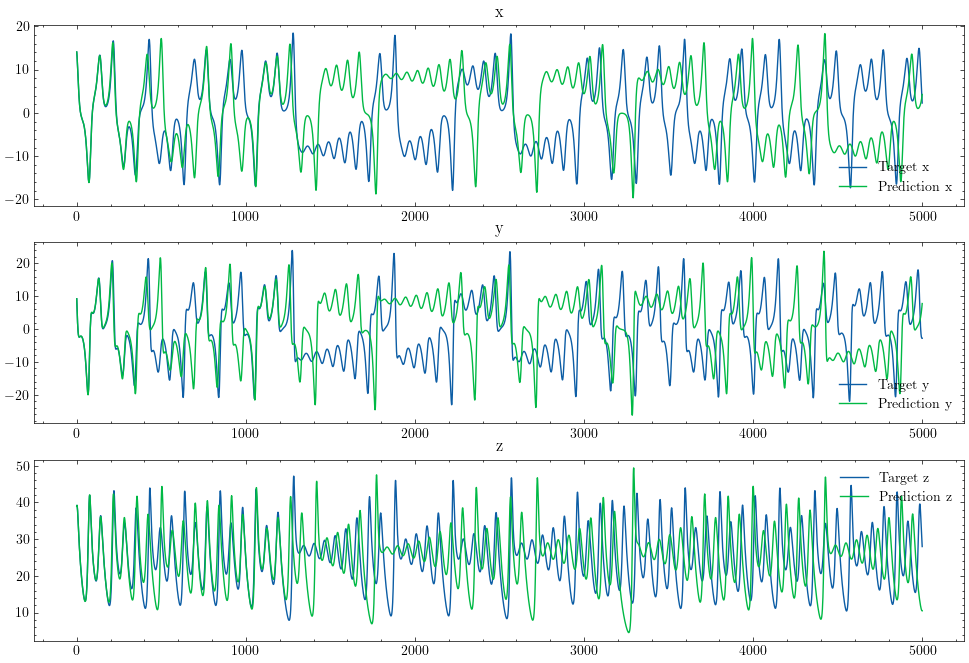

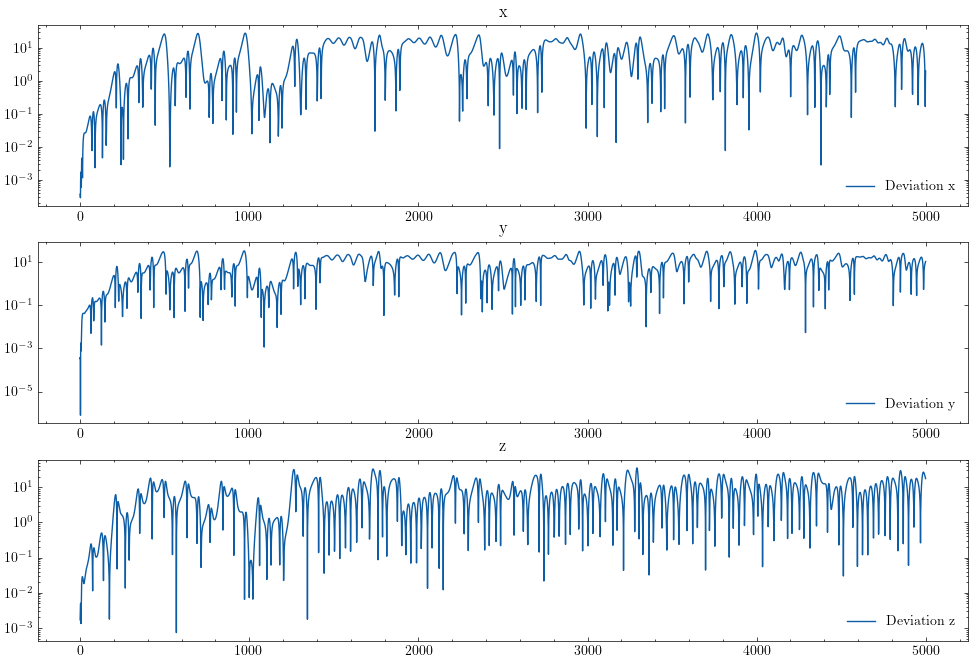

In [91]:
b = 1
if (b):
    label = ['x', 'y', 'z']
    timeTicks = np.arange(0, numberOfIterations, 1)
    plt.figure(figsize=(12,8))
    plt.subplot(311)
    for i in range(dim_system):
        plt.subplot(3,1,i+1)
        plt.plot(testData[:, i], label=f'Target {label[i]}')
        plt.plot(np.array(predictions)[:,i], label=f'Prediction {label[i]}')
        plt.legend()
        plt.title(f'{label[i]}')
        # plt.ylim(-2, 2)
    plt.show()

    plt.figure(figsize=(12,8))
    plt.subplot(311)
    for i in range(dim_system):
        plt.subplot(3,1,i+1)
        plt.plot(deviations[:, i], label=f'Deviation {label[i]}')
        plt.legend()
        plt.title(f'{label[i]}')
        plt.yscale('log')
    

In [92]:
# # histogram of the output weights
# plt.figure(figsize=(8,6))
# plt.hist(W_out.flatten(), bins=100, density=True)
# plt.yscale('log')
# plt.title('Distribution of output weights')
# plt.show()

c.) Train two reservoirs. Once only on one dimension once on all 3 dimensions.


In [93]:
# reservoir parameters
systemDimensions_1d = 1
systemDimensions_3d = 3
reservoirDimension = 300
edgeProbability = 0.1

# scaling factors
scalingFactors = np.linspace(2, 30, 10)

reservoir1D = Reservoir(systemDimensions_1d, reservoirDimension, edgeProbability, 1.1)
reservoir3D = Reservoir(systemDimensions_3d, reservoirDimension, edgeProbability, 1.1)

In [94]:
print(reservoir1D.reservoirState.shape)

(300, 1)


In [95]:
# generate data
x, y, z, t = lorenzSystem(x0,y0,z0,10,28,8/3, numIter=10_000, dt=0.01)

data3D = np.array([x,y,z]).T

# split the data
splitRation = 0.8
trainLength = int(splitRation * data3D.shape[0])
testLength = data3D.shape[0] - trainLength

trainingData3D = data3D[:trainLength]
testData3D = data3D[trainLength:]

# just use the y component
trainingData1D = trainingData3D[:, 1]
testData1D = testData3D[:, 1]
print(trainingData1D.shape)
print(testData1D.shape)



(8000,)
(2000,)


In [96]:
# train the 1D reservoir
W_out_1D, reservoirStateEndTraining_1D = trainReservoir(activation, reservoirState=reservoir1D.reservoirState, reservoirWeights=reservoir1D.W_res, inputWeights=reservoir1D.W_in, data=trainingData1D)

# train the 3D reservoir
W_out_3D, reservoirStateEndTraining_3D = trainReservoir(activation, reservoirState=reservoir3D.reservoirState, reservoirWeights=reservoir3D.W_res, inputWeights=reservoir3D.W_in, data=trainingData3D)


In [97]:
# make predictions 1D
predictions_1D = predictReservoir(activation, reservoirState=reservoirStateEndTraining_1D, reservoirWeights=reservoir1D.W_res, inputWeights=reservoir1D.W_in, data=testData1D, W_out=W_out_1D)

# # make predictions 3D
predictions_3D = predictReservoir(activation, reservoirState=reservoirStateEndTraining_3D, reservoirWeights=reservoir3D.W_res, inputWeights=reservoir3D.W_in, data=testData3D, W_out=W_out_3D)


In [98]:
# compute the deviations
deviations_1D = np.abs(predictions_1D.squeeze() - testData1D.squeeze())
deviations_3D = np.abs(predictions_3D - testData3D)

print(deviations_1D.shape)

(2000,)


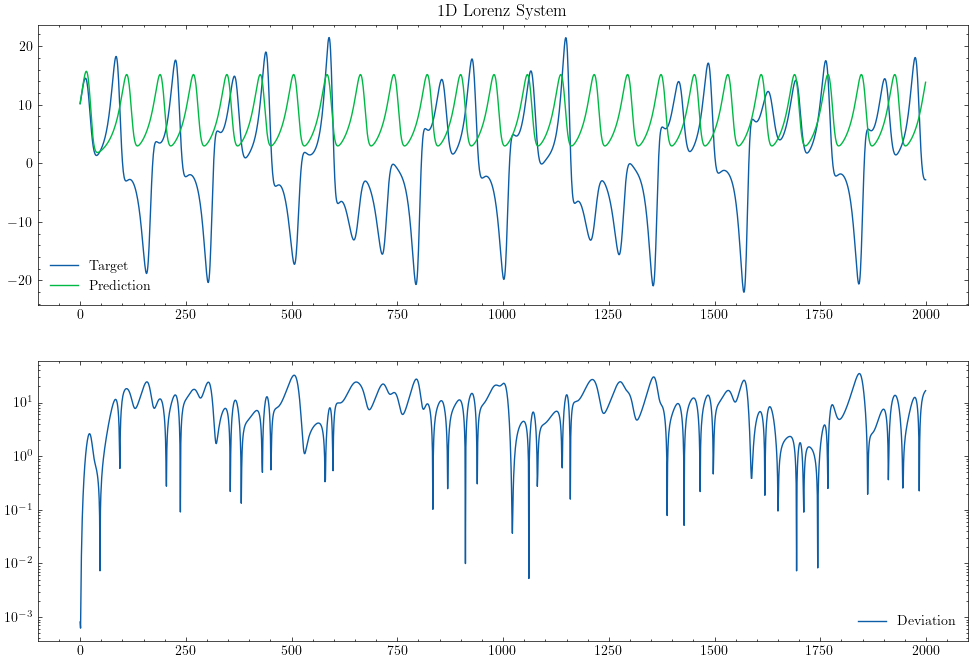

In [99]:
# plot the results of the 1D system
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(testData1D, label='Target')
plt.plot(predictions_1D, label='Prediction')
plt.legend()
plt.title('1D Lorenz System')
plt.subplot(212)
plt.plot(deviations_1D, label='Deviation')
plt.legend()
plt.yscale('log')
plt.show()

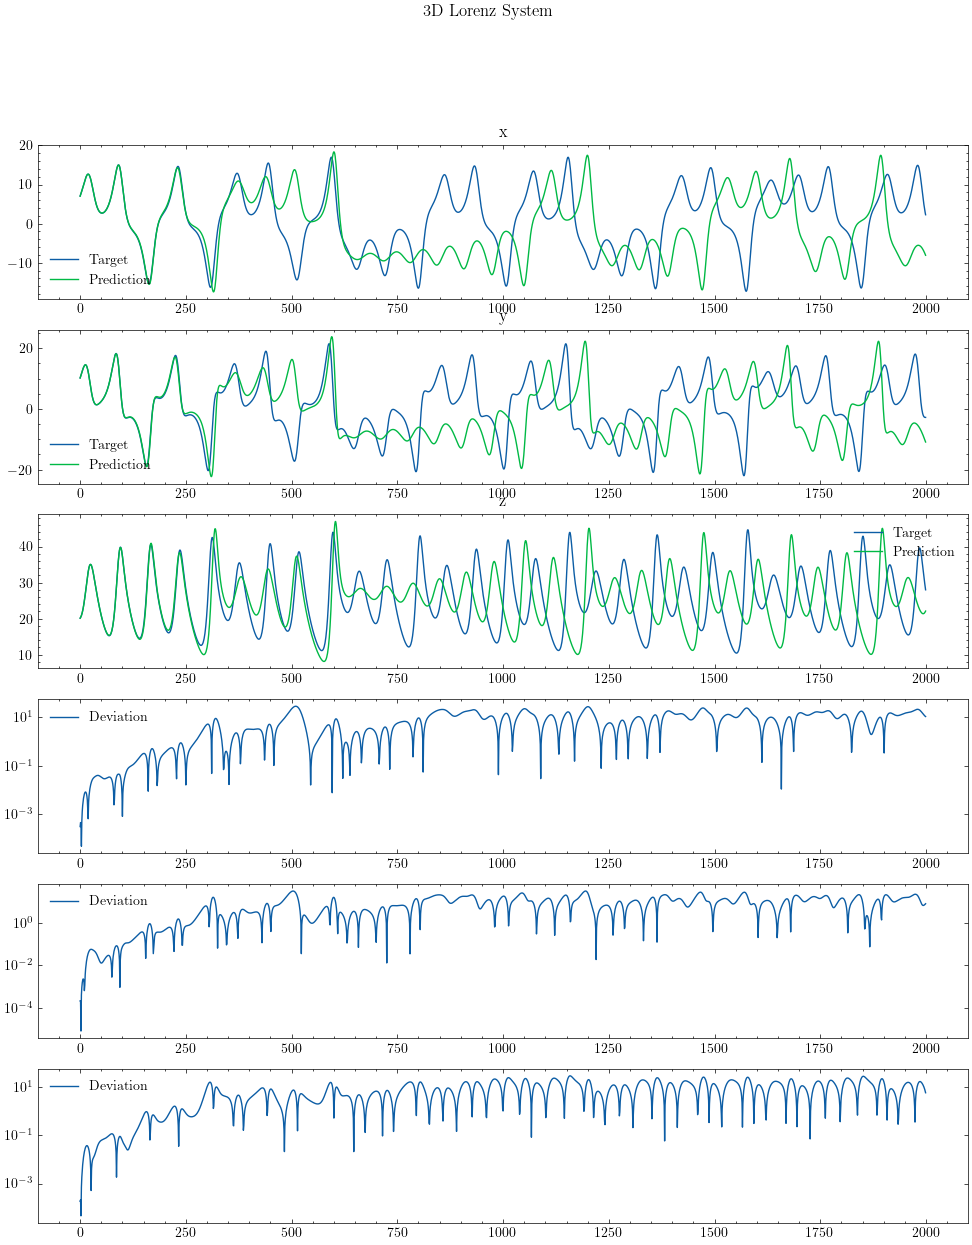

In [100]:
# plot the results of the 3D system
plt.figure(figsize=(12,14))
plt.subplot(611)
for i in range(3):
    plt.subplot(6,1,i+1)
    plt.title(f'{label[i]}')
    plt.plot(testData3D[:, i], label='Target')
    plt.plot(predictions_3D[:, i], label='Prediction')
    plt.legend()
    plt.subplot(6,1,3+i+1)
    plt.plot(deviations_3D[:, i], label='Deviation')
    plt.legend()
    plt.yscale('log')
plt.suptitle('3D Lorenz System')
plt.show()


# Check with different scaling factors


In [101]:
# scaling factors
scalingFactors = np.logspace(-2, 0, 15)
# linear
# scalingFactors = np.linspace(0.001, 1, 25)

# reservoir parameters
systemDimensions_1d = 1
systemDimensions_3d = 3
reservoirDimension = 300
edgeProbability = 0.1
dt = 0.01


# generate data
x, y, z, t = lorenzSystem(1,1,1,10,28,8/3, numIter=10_000, dt=dt)

data3D = np.array([x,y,z]).T

# split the data
splitRation = 0.5
trainLength = int(splitRation * data3D.shape[0])
testLength = data3D.shape[0] - trainLength

trainingData3D = data3D[:trainLength]
testData3D = data3D[trainLength:]

# just use the y component
trainingData1D = trainingData3D[:, 1]
testData1D = testData3D[:, 1]
print(trainingData1D.shape)
print(testData1D.shape)


(5000,)
(5000,)


In [102]:
deviations_1D_tracker = []
deviations_3D_tracker = []
predictions_1D_tracker = []
predictions_3D_tracker = []
maximalSingValue_1D_tracker = []
maximalSingValue_3D_tracker = []

for sf in scalingFactors:
    reservoir1D = Reservoir(systemDimensions_1d, reservoirDimension, edgeProbability, sf)
    # scale down the input weights of the 1D, just as it gives better results
    reservoir1D.scaleInputWeights(0.05)
    reservoir3D = Reservoir(systemDimensions_3d, reservoirDimension, edgeProbability, sf)

    # train the 1D reservoir
    W_out_1D, reservoirStateEndTraining_1D = trainReservoir(activation, reservoirState=reservoir1D.reservoirState, reservoirWeights=reservoir1D.W_res, inputWeights=reservoir1D.W_in, data=trainingData1D);

    # train the 3D reservoir
    W_out_3D, reservoirStateEndTraining_3D = trainReservoir(activation, reservoirState=reservoir3D.reservoirState, reservoirWeights=reservoir3D.W_res, inputWeights=reservoir3D.W_in, data=trainingData3D);

    # make predictions 1D
    predictions_1D = predictReservoir(activation, reservoirState=reservoirStateEndTraining_1D, reservoirWeights=reservoir1D.W_res, inputWeights=reservoir1D.W_in, data=testData1D, W_out=W_out_1D);

    # make predictions 3D
    predictions_3D = predictReservoir(activation, reservoirState=reservoirStateEndTraining_3D, reservoirWeights=reservoir3D.W_res, inputWeights=reservoir3D.W_in, data=testData3D, W_out=W_out_3D);

    # compute the deviations
    deviations_1D = np.abs(predictions_1D.squeeze() - testData1D.squeeze())
    deviations_3D = np.abs(predictions_3D - testData3D)

    # store the predictions
    predictions_1D_tracker.append(predictions_1D)
    predictions_3D_tracker.append(predictions_3D)


    # store the deviations
    deviations_1D_tracker.append(deviations_1D)
    deviations_3D_tracker.append(deviations_3D)

    # maximal singular value tracker
    maximalSingValue_1D_tracker.append(reservoir1D.maxSingularValue)
    maximalSingValue_3D_tracker.append(reservoir3D.maxSingularValue)


In [103]:
# # plot the results of the 1D system
# plt.figure(figsize=(12,8))
numberOfScalings = len(scalingFactors)
# for i in range(numberOfScalings):
#     plt.plot(deviations_1D_tracker[i], label=f'Scaling factor: {maximalSingValue_1D_tracker[i]}')
# plt.grid()
# plt.yscale('log')
# plt.legend()
# plt.show()

In [104]:
upperLimitSteps = 300

# compute the sums of all deviations for the first 300 steps
sums_1D = []
for i in range(numberOfScalings):
    sums_1D.append(np.sum(deviations_1D_tracker[i][:int(upperLimitSteps/4)]))

# plt.figure(figsize=(12,8))
# # bar plot
# plt.title("Sum of deviations for the first 300 steps - 1D System")
# plt.bar(np.arange(numberOfScalings), sums_1D)
# plt.xticks(np.arange(numberOfScalings), scalingFactors)
# plt.xlabel('Scaling factors')
# plt.ylabel('Sum of deviations')
# plt.xticks(rotation=45)
# plt.yscale('log')

In [105]:
# plot the results of the 3D system


# compute the sums of all deviations for the first 300 steps
sums_3D = []
for i in range(numberOfScalings):
    sums_3D.append(np.sum(deviations_3D_tracker[i][:upperLimitSteps]))

# plt.figure(figsize=(12,8))
# # bar plot
# plt.title("Sum of deviations for the first 300 steps - 1D System")
# plt.bar(np.arange(numberOfScalings), sums_3D)
# plt.xticks(np.arange(numberOfScalings), scalingFactors)
# plt.xlabel('Scaling factors')
# plt.ylabel('Sum of deviations')
# plt.xticks(rotation=45)
# plt.yscale('log')

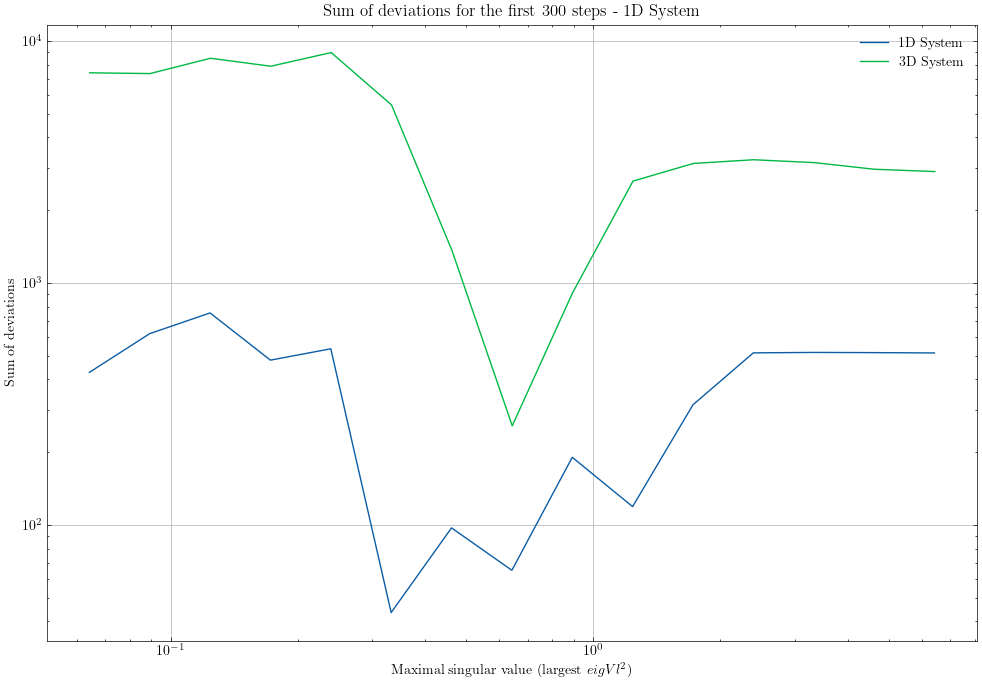

In [106]:
# Comparison
plt.figure(figsize=(12,8))
# bar plot
plt.title("Sum of deviations for the first 300 steps - 1D System")
# plt.bar(np.arange(numberOfScalings), sums_1D, label='1D System', alpha=0.5)
# plt.bar(np.arange(numberOfScalings), sums_3D, label='3D System', alpha=0.5)
plt.plot(maximalSingValue_1D_tracker, sums_1D, label='1D System')
plt.plot(maximalSingValue_3D_tracker, sums_3D, label='3D System')

plt.grid()
plt.xlabel('Maximal singular value (largest $eigVl^2$)')
plt.ylabel('Sum of deviations')
# plt.xticks(rotation=45)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.show()

Best 1D system: 0.0517947467923121, 5
Best 3D system: 0.1, 7


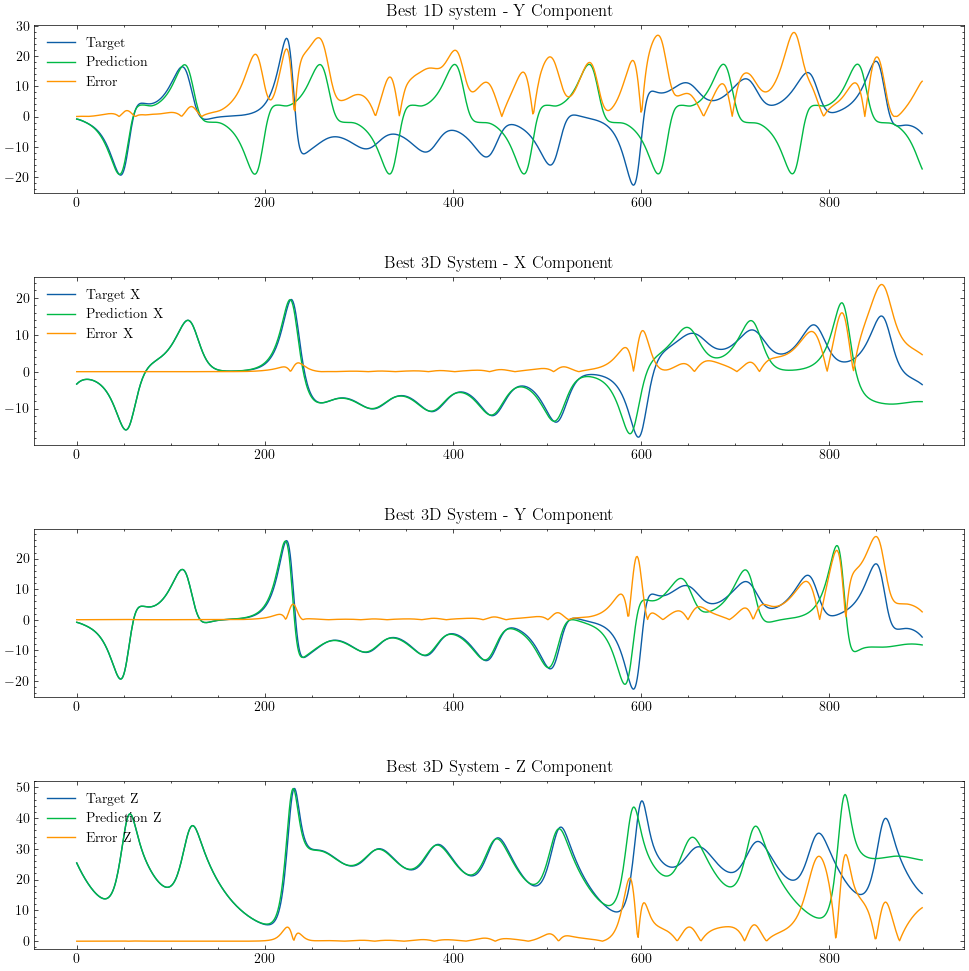

In [107]:
# find the best 1D and 3D system
best1D = np.argmin(sums_1D)
best3D = np.argmin(sums_3D)
CUTOFF = 900

print(f"Best 1D system: {scalingFactors[best1D]}, {best1D}")
print(f"Best 3D system: {scalingFactors[best3D]}, {best3D}")

# plot the predictions of the best 1D and 3D system
plt.figure(figsize=(12,12))
# add vertical spacing
plt.subplots_adjust(hspace=0.5)


plt.subplot(411)
plt.title('Best 1D system - Y Component')
plt.plot(testData1D[:CUTOFF], label='Target')
plt.plot(predictions_1D_tracker[best1D][:CUTOFF], label='Prediction')
div = np.abs(testData1D-predictions_1D_tracker[best1D].squeeze())
div = div[:CUTOFF]
plt.plot(div, label='Error')
plt.legend()

plt.subplot(412)
plt.title("Best 3D System - X Component")
plt.plot(testData3D[:CUTOFF, 0], label='Target X')
plt.plot(predictions_3D_tracker[best3D][:CUTOFF, 0], label='Prediction X')
plt.plot(abs(testData3D[:CUTOFF, 0]-predictions_3D_tracker[best3D][:CUTOFF, 0]), label='Error X')
plt.legend()
plt.subplot(413)
plt.title("Best 3D System - Y Component")
plt.plot(testData3D[:CUTOFF, 1], label='Target Y')
plt.plot(predictions_3D_tracker[best3D][:CUTOFF, 1], label='Prediction Y')
plt.plot(abs(testData3D[:CUTOFF, 1]-predictions_3D_tracker[best3D][:CUTOFF, 1]), label='Error Y')

# plt.legend()
plt.subplot(414)
plt.title("Best 3D System - Z Component")
plt.plot(testData3D[:CUTOFF, 2], label='Target Z')
plt.plot(predictions_3D_tracker[best3D][:CUTOFF, 2], label='Prediction Z')
plt.plot(abs(testData3D[:CUTOFF, 2]-predictions_3D_tracker[best3D][:CUTOFF, 2]), label='Error Z')
plt.legend()

plt.show()

4.) Compute the maximal Lyapunov exponent of the Lorenz system


In [108]:
# as in DYS HW 4.3 

from scipy.integrate import odeint
# define the Lorenz system
def lorenz_system(state, t, sigma, r, b):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (r - z) - y
    dzdt = x * y - b * z
    return [dxdt, dydt, dzdt]

# define the Lorenz Jacobian
def lorenz_jacobian(state, t, sigma, r, b):
    x, y, z = state
    J = np.array([
        [-sigma, sigma, 0],
        [r - z, -1, -x],
        [y, x, -b]
    ])
    return J

def solveLorenz(initState, sigma, r, b, N, dt):
    # solve the system
    x = odeint(lorenz_system, initState, np.arange(0, N*dt, dt), args=(sigma, r, b))
    return x



def computeLyapunov(initState, sigma, r, b, N, Nstart, dt):

    # 1.) solve the system to get the trajectory
    x = odeint(lorenz_system, initState, np.arange(0, N*dt, dt), args=(sigma, r, b))

    # 2.) init Q, M0 and li
    Q = np.identity(3)
    M0 = np.identity(3)
    li = np.zeros(3)
    li_tracker = np.zeros((N-Nstart, 3))

    Q_old = Q

    # skip the first Nstart steps  

    for n in trange(N):
        
        # skip the first Nstart steps
        if n < Nstart:
            continue

        M_n = np.identity(3) + lorenz_jacobian(x[n], n*dt, sigma, r, b) * dt
        Q, R = np.linalg.qr(np.matmul(M_n, Q_old))
        Q_old = Q

        Rii = np.log(np.abs(np.diag(R)))
        #print(Rii)
        # add the R_ii to li
        li[0] += Rii[0]
        li[1] += Rii[1]
        li[2] += Rii[2]

        # add li to the tracker and normalize
        li_tracker[n-Nstart] = li / (n*dt)

    # Normalize the li
    li /= (N * dt)

    return li, li_tracker

    

In [109]:
# set parameters
sigma = 10
b = 8/3
r = 28

# set initial state
initState = [0.01,0.01,0.01]                  # norm of the initial state must be small << 1
tMax = 1e3
tStart = 5
dT = 1e-3
N = int(tMax / dT)
nStart = int(tStart / dT)

# compute the Lyapunov exponents
LYE_tracker_1 = computeLyapunov(initState, sigma, r, b, N, nStart, dT)
Li = LYE_tracker_1[0]
# sort Li descending
Li = np.sort(Li)[::-1]

# print the Lyapunov exponents
print("Lyapunov exponents:", Li)

100%|██████████| 1000000/1000000 [00:18<00:00, 54793.39it/s]

Lyapunov exponents: [  0.93767625   0.03774462 -14.61028885]


Text(0.5, 1.0, '$\\sigma$ = 10, r = 28, b = 2.667')

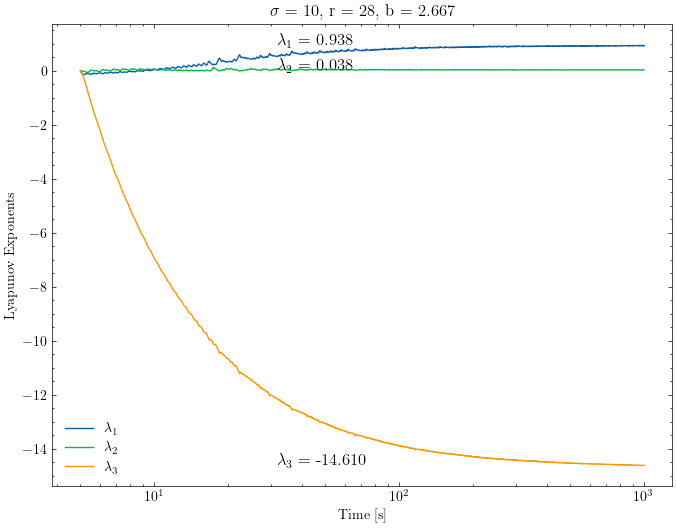

In [114]:
# set parameters
sigma = 10
b = 8/3
r = 28

Li_Tracker_1 = LYE_tracker_1[1]

# time array from nStart/dT to n/dt
time = np.linspace(tStart, tMax, int((tMax-tStart)/dT))

plt.figure(figsize=(8,6))
plt.semilogx(time, Li_Tracker_1[:,0], label="$\lambda_1$")
plt.semilogx(time, Li_Tracker_1[:,1], label="$\lambda_2$")
plt.semilogx(time, Li_Tracker_1[:,2], label="$\lambda_3$")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Lyapunov Exponents")
plt.legend(["$\lambda_1$", "$\lambda_2$", "$\lambda_3$"])

# write final value of the Lyapunov exponents into plot
plt.text(10**1.5, Li_Tracker_1[-1,0], "$\lambda_1$ = {:.3f}".format(Li[0]), fontsize=12)
plt.text(10**1.5, Li_Tracker_1[-1,1], "$\lambda_2$ = {:.3f}".format(Li[1]), fontsize=12)
plt.text(10**1.5, Li_Tracker_1[-1,2], "$\lambda_3$ = {:.3f}".format(Li[2]), fontsize=12)

# plt title with the parameters simga, r and b
plt.title("$\sigma$ = {}, r = {}, b = {:.3f}".format(sigma, r, b))

So $\lambda_1 = 1.173$ and therefore $t_{lyap} = 1 / 1.173 = 0.85251$


In [111]:
maxLypunovExp = Li[0]
lyapTime = 1 / maxLypunovExp

timeVector = np.linspace(0, testData1D.shape[0], testData1D.shape[0])
timeVector = timeVector * dt / lyapTime



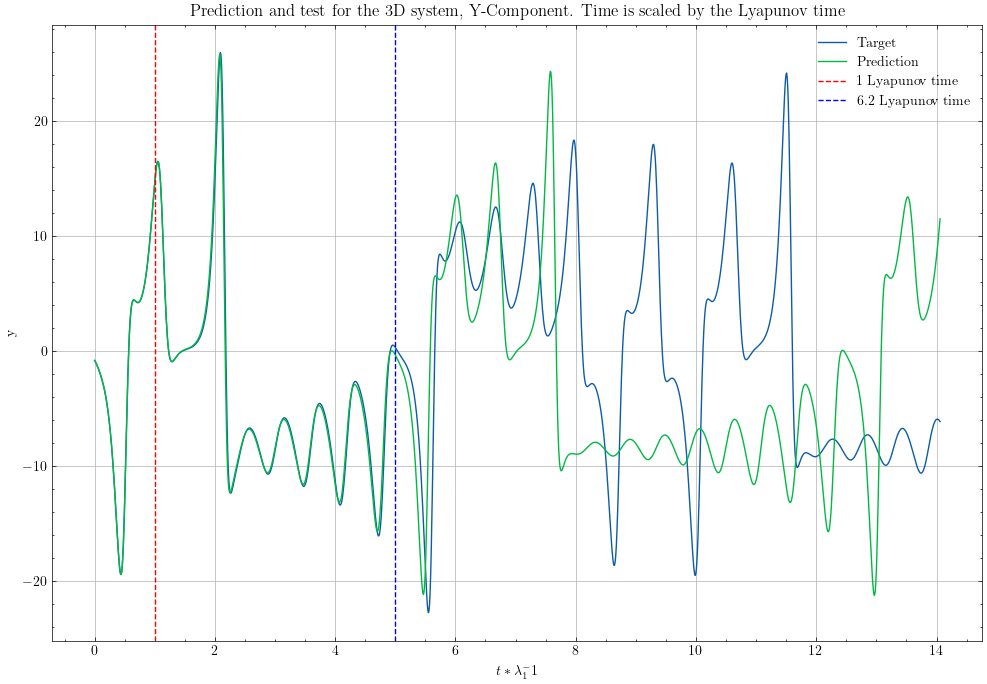

In [112]:
CUTOFF = 1500
timeVector = timeVector[:CUTOFF]

plt.figure(figsize=(12,8))
plt.plot(timeVector, testData1D[:CUTOFF], label='Target')
plt.plot(timeVector, predictions_3D_tracker[best3D][:CUTOFF,1], label='Prediction')
# add a vertical line at the lyapunov time
plt.axvline(x=1, color='r', linestyle='--', label='1 Lyapunov time')
plt.axvline(x=5, color='b', linestyle='--', label='6.2 Lyapunov time')

plt.xlabel('$t * \lambda_1 ^-1$')
plt.ylabel('y')
plt.legend()
plt.title("Prediction and test for the 3D system, Y-Component. Time is scaled by the Lyapunov time")

plt.grid()

I would say, the system gets well predict up to about 6.2 laypunov times


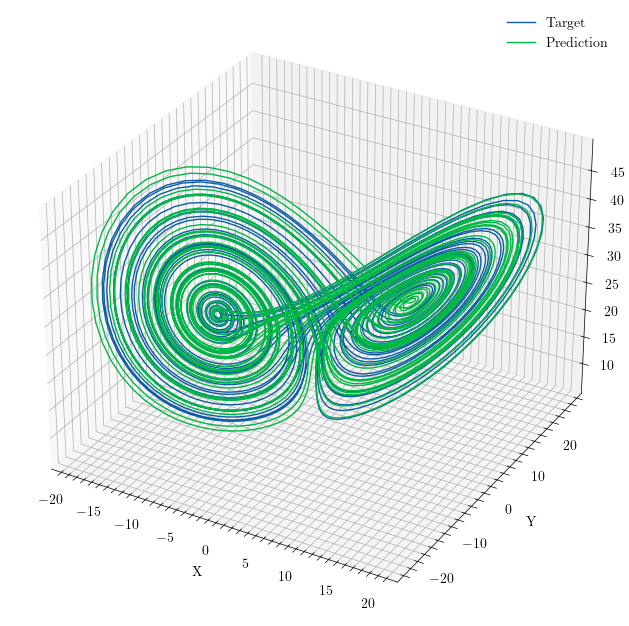

In [115]:
# visualize the 3D system
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(testData3D[:,0], testData3D[:,1], testData3D[:,2], label='Target')
ax.plot(predictions_3D_tracker[best3D][:,0], predictions_3D_tracker[best3D][:,1], predictions_3D_tracker[best3D][:,2], label='Prediction')
plt.legend()

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()
